In [66]:
# !pip install google-generativeai
# !pip install langgraph

In [67]:
# from google.colab import drive
# drive.mount('/content/drive')

In [68]:
import os
import re
import json
import google.generativeai as genai
from typing import Dict, Any, List, Tuple
import getpass

In [69]:
# --- CẤU HÌNH API KEY ---

try:
    from google.colab import userdata
    GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
    if GOOGLE_API_KEY is None:
        raise ImportError
except ImportError:
    try:
        GOOGLE_API_KEY = getpass.getpass("Vui lòng nhập Google API Key của bạn: ")
    except Exception as e:
        print(f"Không thể đọc API Key: {e}")
        GOOGLE_API_KEY = None

if GOOGLE_API_KEY:
    try:
        genai.configure(api_key=GOOGLE_API_KEY)
    except Exception as e:
        print(f"Lỗi cấu hình API: {e}")
else:
    print("LỖI: Không có API Key được cung cấp. Vui lòng chạy lại ô này và nhập key.")

In [70]:
class LLMClient:
    def __init__(self, model_name="gemini-1.5-flash"):
        self.model = genai.GenerativeModel(model_name)

    def generate(self, prompt: str) -> str:
        try:
            response = self.model.generate_content(prompt)
            return response.text
        except Exception as e:
            print(f"Đã xảy ra lỗi khi gọi API của LLM: {e}")
            return f"Lỗi: Không thể tạo nội dung. {e}"

class SkillTree:
    def __init__(self, abilities: Dict[str, Any]):
        self.abilities = abilities

    def __str__(self) -> str:
        return json.dumps(self.abilities, ensure_ascii=False, indent=2)

class LessonPlan:
    def __init__(self, topic: str, knowledge_points: str, exercises: List[Dict[str, Any]]):
        self.topic = topic
        self.knowledge_points = knowledge_points
        self.exercises = exercises

    def __str__(self) -> str:
        exercise_str = ""
        for i, ex in enumerate(self.exercises):
            exercise_str += f"\n--- Bài tập {i+1} ---\n"
            exercise_str += f"Câu hỏi: {ex.get('question', 'Chưa có')}\n"
            exercise_str += f"Giải pháp: {ex.get('solution', 'Chưa có')}\n"
            exercise_str += f"Các lỗi sai thường gặp: {ex.get('common_mistakes', 'Chưa có')}\n"

        return f"""
==================================================
CHỦ ĐỀ GIÁO ÁN: {self.topic}
==================================================

PHẦN 1: GIẢI THÍCH KIẾN THỨC
---------------------------------
{self.knowledge_points}

PHẦN 2: BÀI TẬP VẬN DỤNG
---------------------------------
{exercise_str}
==================================================
"""

In [71]:
from typing import TypedDict

class LessonPlanState(TypedDict):
    lesson_plan: LessonPlan
    evaluation_feedback: Dict[str, Any]
    student_scores: List[int]
    skill_tree: SkillTree
    iterations: int
    max_iterations: int

In [72]:
class EvaluatorAgent:
    def __init__(self, llm_client: LLMClient):
        self.llm_client = llm_client

    def _parse_evaluation(self, text: str) -> Tuple[Dict[str, Any], int]:
        try:
            clarity_match = re.search(r"Clarity:\s*(\d+)/100\.\s*(.*)", text, re.IGNORECASE)
            integrity_match = re.search(r"Integrity:\s*(\d+)/100\.\s*(.*)", text, re.IGNORECASE)
            depth_match = re.search(r"Depth:\s*(\d+)/100\.\s*(.*)", text, re.IGNORECASE)
            practicality_match = re.search(r"Practicality:\s*(\d+)/100\.\s*(.*)", text, re.IGNORECASE)
            pertinence_match = re.search(r"Pertinence:\s*(\d+)/100\.\s*(.*)", text, re.IGNORECASE)

            scores = {
                "Clarity": int(clarity_match.group(1)) if clarity_match else 0,
                "Integrity": int(integrity_match.group(1)) if integrity_match else 0,
                "Depth": int(depth_match.group(1)) if depth_match else 0,
                "Practicality": int(practicality_match.group(1)) if practicality_match else 0,
                "Pertinence": int(pertinence_match.group(1)) if pertinence_match else 0,
            }

            feedback = {
                "Clarity": clarity_match.group(2).strip() if clarity_match else "Không có phân tích.",
                "Integrity": integrity_match.group(2).strip() if integrity_match else "Không có phân tích.",
                "Depth": depth_match.group(2).strip() if depth_match else "Không có phân tích.",
                "Practicality": practicality_match.group(2).strip() if practicality_match else "Không có phân tích.",
                "Pertinence": pertinence_match.group(2).strip() if pertinence_match else "Không có phân tích.",
            }

            overall_score = sum(scores.values()) // len(scores) if scores else 0
            return {"scores": scores, "feedback": feedback}, overall_score
        except Exception as e:
            print(f"Lỗi phân tích đánh giá: {e}. Văn bản nhận được: '{text}'")
            return {"scores": {}, "feedback": {"error": "Lỗi định dạng phản hồi từ LLM"}}, 0

    def evaluate(self, state: LessonPlanState) -> Dict[str, Any]:
        lesson_plan = state['lesson_plan']
        student_scores = state['student_scores']
        skill_tree = state['skill_tree']

        student_scores_str = f"Student Scores on Skill-Tree Abilities: {student_scores}"

        prompt = f"""Role: Bạn là một chuyên gia đánh giá nội dung giáo dục và thiết kế giảng dạy khách quan. Task: Đánh giá chất lượng của giáo án được cung cấp dựa trên 5 tiêu chí cụ thể dưới đây và hồ sơ năng lực (Skill-Tree) cùng điểm số cụ thể của học sinh. Đánh giá của bạn phải hoàn toàn khách quan. Student Profile (Skill-Tree):\n{skill_tree}\n{student_scores_str}\n\nLesson Plan to Evaluate:\n{lesson_plan}\n\nEvaluation Standard (CIDDP - 5-dimensional evaluation):\n1.  **Clarity (Tính rõ ràng):** Mức độ trực tiếp và đơn giản của giáo án, tránh sự phức tạp không cần thiết.\n2.  **Integrity (Tính toàn vẹn):** Giáo án có đầy đủ, hệ thống, bao gồm cả giải thích kiến thức và bài tập không?\n3.  **Depth (Độ sâu):** Khả năng của giáo án trong việc truyền cảm hứng tư duy sâu sắc và hiểu các mối liên hệ kiến thức.\n4.  **Practicality (Tính thực tiễn):** Giá trị ứng dụng của các ví dụ, đảm bảo học sinh có thể dùng kiến thức giải quyết vấn đề thực tế.\n5.  **Pertinence (Tính phù hợp):** Mức độ phù hợp của giáo án với trình độ và nhu cầu học tập của học sinh dựa trên Skill-Tree và điểm số cụ thể.\n\nConstraints: Đánh giá từng khía cạnh một cách độc lập. Đừng thiên vị bất kỳ cấu trúc hay thuật ngữ nào.\n\nWorkflow & Output Format: Đưa ra nhận định cuối cùng của bạn theo định dạng CHÍNH XÁC sau đây. Mỗi dòng một tiêu chí, chấm điểm trên thang 100 và đưa ra phân tích ngắn gọn.\n\nClarity: [điểm]/100. [phân tích ngắn gọn ưu và nhược điểm]\nIntegrity: [điểm]/100. [phân tích ngắn gọn ưu và nhược điểm]\nDepth: [điểm]/100. [phân tích ngắn gọn ưu và nhược điểm]\nPracticality: [điểm]/100. [phân tích ngắn gọn ưu và nhược điểm]\nPertinence: [điểm]/100. [phân tích ngắn gọn ưu và nhược điểm]"""
        response_text = self.llm_client.generate(prompt)
        evaluation_feedback, score = self._parse_evaluation(response_text)

        return {"evaluation_feedback": evaluation_feedback}



In [73]:
class AnalystAgent:
    def __init__(self, llm_client: LLMClient):
        self.llm_client = llm_client

    def _parse_analysis(self, text: str) -> str:
        return text.strip()

    def analyze_and_enrich(self, state: LessonPlanState) -> Dict[str, Any]:
        lesson_plan = state['lesson_plan']
        student_scores = state['student_scores']
        skill_tree = state['skill_tree']

        enriched_exercises = []
        student_scores_str = f"Student Scores on Skill-Tree Abilities: {student_scores}"
        for exercise in lesson_plan.exercises:
            prompt = f"""Role: Bạn là một giáo viên dạy môn Lập trình hướng đối tượng với Java nhiều kinh nghiệm. Task: Dựa vào câu hỏi bài tập, giải pháp và hồ sơ năng lực (Skill-Tree) cùng điểm số cụ thể của học sinh, hãy xác định 2-3 lỗi sai phổ biến nhất mà một học sinh có trình độ này có thể mắc phải. Trình bày các lỗi sai một cách rõ ràng, dễ hiểu. Student Profile (Skill-Tree):\n{skill_tree}\n{student_scores_str}\n\nExercise Question: {exercise.get('question')}\nExercise Solution: {exercise.get('solution')}\n\nOutput Format: Chỉ trả về phần phân tích các lỗi sai, không thêm bất kỳ lời chào hay giải thích nào khác. Bắt đầu bằng gạch đầu dòng."""
            common_mistakes = self._parse_analysis(self.llm_client.generate(prompt))

            updated_exercise = exercise.copy()
            updated_exercise['common_mistakes'] = common_mistakes
            enriched_exercises.append(updated_exercise)

        return {"lesson_plan": LessonPlan(
            topic=lesson_plan.topic,
            knowledge_points=lesson_plan.knowledge_points,
            exercises=enriched_exercises
        )}

In [74]:
class OptimizerAgent:
    def __init__(self, llm_client: LLMClient):
        self.llm_client = llm_client

    def _parse_optimized_plan(self, text: str, topic: str) -> LessonPlan:
        try:
            knowledge_match = re.search(r"PHẦN 1: GIẢI THÍCH KIẾN THỨC\s*-+\s*(.*?)\s*PHẦN 2: BÀI TẬP VẬN DỤNG", text, re.DOTALL | re.IGNORECASE)
            exercises_text_match = re.search(r"PHẦN 2: BÀI TẬP VẬN DỤNG\s*-+\s*(.*)", text, re.DOTALL | re.IGNORECASE)

            knowledge_points = knowledge_match.group(1).strip() if knowledge_match else "Không thể trích xuất kiến thức."
            exercises_text = exercises_text_match.group(1).strip() if exercises_text_match else ""

            exercises = []
            exercise_blocks = re.split(r"---\s*Bài tập\s*\d+\s*---", exercises_text)
            for block in exercise_blocks:
                if not block.strip():
                    continue
                question_match = re.search(r"Câu hỏi:\s*(.*?)(?:\nGiải pháp:|\Z)", block, re.DOTALL)
                solution_match = re.search(r"Giải pháp:\s*(.*)", block, re.DOTALL)

                if question_match:
                    exercises.append({
                        "question": question_match.group(1).strip(),
                        "solution": solution_match.group(1).strip() if solution_match else "Chưa có giải pháp.",
                        "common_mistakes": ""
                    })
            return LessonPlan(topic, knowledge_points, exercises)
        except Exception as e:
            print(f"Lỗi phân tích giáo án tối ưu: {e}")
            return LessonPlan(topic, "Lỗi định dạng phản hồi từ LLM.", [])

    def optimize(self, state: LessonPlanState) -> Dict[str, Any]:
        previous_plan = state['lesson_plan']
        evaluation_feedback = state['evaluation_feedback']
        student_scores = state['student_scores']
        skill_tree = state['skill_tree']

        feedback_str = json.dumps(evaluation_feedback.get('feedback', {}), ensure_ascii=False, indent=2)
        student_scores_str = f"Student Scores on Skill-Tree Abilities: {student_scores}"


        prompt = f"""Role: Bạn là một nhà thiết kế chương trình giảng dạy sáng tạo và thông minh. Task: Cải thiện và viết lại một giáo án mới dựa trên phiên bản cũ và các phản hồi đánh giá. Mục tiêu là tạo ra một giáo án tốt hơn, khắc phục được các nhược điểm đã chỉ ra. Student Profile (Skill-Tree):\n{skill_tree}\n{student_scores_str}\n\nPrevious Lesson Plan:\n{previous_plan}\n\nEvaluation Feedback (Advantages and Disadvantages):\n{feedback_str}\n\nInstruction: Tập trung vào việc cải thiện các điểm bị đánh giá thấp. Giữ lại những điểm mạnh đã được ghi nhận. Tạo ra nội dung mới phù hợp hơn với học sinh, có chiều sâu và thực tiễn hơn. Đảm bảo giáo án mới có 2 phần rõ ràng: giải thích kiến thức và bài tập vận dụng (bao gồm 3 bài tập từ dễ đến khó).\n\nOutput Format: Trả về giáo án mới theo định dạng CHÍNH XÁC sau:\n\nPHẦN 1: GIẢI THÍCH KIẾN THỨC\n---------------------------------\n[Nội dung kiến thức mới]\n\nPHẦN 2: BÀI TẬP VẬN DỤNG\n---------------------------------\n--- Bài tập 1 ---\nCâu hỏi: [Câu hỏi bài tập 1]\nGiải pháp: [Các bước giải chi tiết cho bài tập 1]\n\n--- Bài tập 2 ---\nCâu hỏi: [Câu hỏi bài tập 2]\nGiải pháp: [Các bước giải chi tiết cho bài tập 2]\n\n--- Bài tập 3 ---\nCâu hỏi: [Câu hỏi bài tập 3]\nGiải pháp: [Các bước giải chi tiết cho bài tập 3]"""

        optimized_text = self.llm_client.generate(prompt)
        optimized_plan = self._parse_optimized_plan(optimized_text, previous_plan.topic)

        return {"lesson_plan": optimized_plan, "iterations": state.get("iterations", 0) + 1}

In [75]:
from langgraph.graph import StateGraph, END

def should_continue_optimization(state: LessonPlanState):
    return "continue" if state.get("iterations", 0) < state.get("max_iterations", 0) else "end"


llm = LLMClient()

evaluator_agent = EvaluatorAgent(llm)
analyst_agent = AnalystAgent(llm)
optimizer_agent = OptimizerAgent(llm)

workflow = StateGraph(LessonPlanState)

workflow.add_node("analyst", analyst_agent.analyze_and_enrich)
workflow.add_node("evaluator", evaluator_agent.evaluate)
workflow.add_node("optimizer", optimizer_agent.optimize)

workflow.set_entry_point("evaluator")
workflow.add_edge("evaluator", "analyst")
workflow.add_edge("analyst", "optimizer")

workflow.add_conditional_edges(
    "optimizer",
    should_continue_optimization,
    {
        "continue": "evaluator",
        "end": END
    }
)

app = workflow.compile()

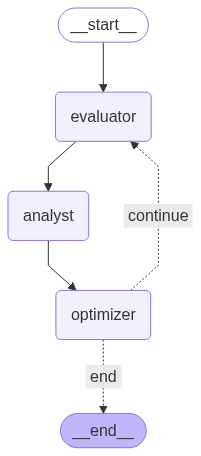

In [76]:
from IPython.display import Image, display
display(Image(app.get_graph(xray=1).draw_mermaid_png()))

In [77]:
class EduPlanner:
    def __init__(self, llm_client: LLMClient):
        self.evaluator = EvaluatorAgent(llm_client)
        self.optimizer = OptimizerAgent(llm_client)
        self.analyst = AnalystAgent(llm_client)
        self.llm_client = llm_client
        self.final_lesson_plan = None

    def run_optimization_loop(self, topic: str, student_scores: List[int], skill_tree: SkillTree, initial_plan: LessonPlan = None, num_iterations: int = 3):

        current_plan = initial_plan
        initial_evaluation_feedback = {}


        initial_state = LessonPlanState(
            lesson_plan=current_plan,
            evaluation_feedback=initial_evaluation_feedback,
            student_scores=student_scores,
            skill_tree=skill_tree,
            iterations=0,
            max_iterations=num_iterations
        )

        last_state = None
        try:
            for s in app.stream(initial_state):
                print("\n--- Bước xử lý ---")
                for key, value in s.items():
                    print(f"Node: {key}")
                    if isinstance(value, dict):
                         if 'evaluation_feedback' in value and value['evaluation_feedback']:
                              print("  Evaluation Scores:", value['evaluation_feedback'].get('scores'))
                              scores = value['evaluation_feedback'].get('scores')
                              if scores:
                                  overall_score = sum(scores.values()) // len(scores)
                                  print(f"  Overall Evaluation Score: {overall_score}/100")
                    else:
                        print("  Output:", value)
                last_state = s

            print("\n\n##################################################")
            print("           QUÁ TRÌNH TỐI ƯU HOÀN TẤT           ")
            print("##################################################")

            if last_state and END in last_state and 'lesson_plan' in last_state[END]:
                 self.final_lesson_plan = last_state[END]['lesson_plan']
            elif last_state:
                 for value in last_state.values():
                     if isinstance(value, dict) and 'lesson_plan' in value and value['lesson_plan'] is not None:
                         self.final_lesson_plan = value['lesson_plan']
                         break


            if self.final_lesson_plan:
                 print("\n--- Giáo án cuối cùng đã tối ưu ---")
                 print(self.final_lesson_plan)
            else:
                 print("Không thể tìm thấy giáo án cuối cùng sau quá trình tối ưu hóa.")


        except Exception as e:
            print(f"\nLỖI XẢY RA KHI CHẠY LANGGRAPH: {e}")
            print("\nQuá trình tối ưu hóa không hoàn thành.")
            self.final_lesson_plan = None

In [78]:
def parse_lesson_plan_from_text(text: str) -> LessonPlan:
    topic_match = re.search(r"CHỦ ĐỀ GIÁO ÁN:\s*(.*?)\s*==================================================", text, re.DOTALL | re.IGNORECASE)
    knowledge_match = re.search(r"PHẦN 1: GIẢI THÍCH KIẾN THỨC\s*-+\s*(.*?)\s*PHẦN 2: BÀI TẬP VẬN DỤNG", text, re.DOTALL | re.IGNORECASE)
    exercises_text_match = re.search(r"PHẦN 2: BÀI TẬP VẬN DỤNG\s*-+\s*(.*)", text, re.DOTALL | re.IGNORECASE)

    topic = topic_match.group(1).strip() if topic_match else "Unknown Topic"
    knowledge_points = knowledge_match.group(1).strip() if knowledge_match else "Không thể trích xuất kiến thức."
    exercises_text = exercises_text_match.group(1).strip() if exercises_text_match else ""

    exercises = []
    exercise_blocks = re.split(r"---\s*Bài tập\s*\d+\s*---", exercises_text)
    for block in exercise_blocks:
        if not block.strip():
            continue
        question_match = re.search(r"Câu hỏi:\s*(.*?)(?:\nGiải pháp:|\Z)", block, re.DOTALL)
        solution_match = re.search(r"Giải pháp:\s*(.*)", block, re.DOTALL)

        if question_match:
            exercises.append({
                "question": question_match.group(1).strip(),
                "solution": solution_match.group(1).strip() if solution_match else "Chưa có giải pháp.",
                "common_mistakes": ""
            })
    return LessonPlan(topic, knowledge_points, exercises)

In [81]:
with open("/content/drive/MyDrive/Edu_Planner/lessonplan/oop_with_java_lessonplan.txt", 'r', encoding='utf-8') as f:
    lesson_plan_text_from_file = f.read()

with open("/content/drive/MyDrive/Edu_Planner/persona/oop_with_java_tree.json", 'r', encoding='utf-8') as f:
    skill_tree_data = json.load(f)
skill_tree = SkillTree(skill_tree_data)


In [83]:
skill_tree = None
student_scores = [4, 4, 3, 4, 3]

initial_lesson_plan_score = 20

initial_lesson_plan = parse_lesson_plan_from_text(lesson_plan_text_from_file)
lesson_topic = initial_lesson_plan.topic


planner = EduPlanner(llm)

planner.run_optimization_loop(
    topic=lesson_topic,
    student_scores=student_scores,
    skill_tree=skill_tree,
    initial_plan=initial_lesson_plan,
    num_iterations=3
    )


--- Bước xử lý ---
Node: evaluator
  Evaluation Scores: {'Clarity': 85, 'Integrity': 60, 'Depth': 70, 'Practicality': 40, 'Pertinence': 75}
  Overall Evaluation Score: 66/100

--- Bước xử lý ---
Node: analyst

--- Bước xử lý ---
Node: optimizer

--- Bước xử lý ---
Node: evaluator
  Evaluation Scores: {'Clarity': 95, 'Integrity': 90, 'Depth': 75, 'Practicality': 85, 'Pertinence': 80}
  Overall Evaluation Score: 85/100

--- Bước xử lý ---
Node: analyst

--- Bước xử lý ---
Node: optimizer

--- Bước xử lý ---
Node: evaluator
  Evaluation Scores: {'Clarity': 95, 'Integrity': 90, 'Depth': 80, 'Practicality': 85, 'Pertinence': 75}
  Overall Evaluation Score: 85/100

--- Bước xử lý ---
Node: analyst

--- Bước xử lý ---
Node: optimizer


##################################################
           QUÁ TRÌNH TỐI ƯU HOÀN TẤT           
##################################################

--- Giáo án cuối cùng đã tối ưu ---

CHỦ ĐỀ GIÁO ÁN: Lập trình hướng đối tượng với Java

PHẦN 1: GIẢI THÍCH K